In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy as cp
import seaborn as sns
import warnings
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
warnings.filterwarnings("ignore")

In [2]:
df_ori = pd.read_csv('Dataset 2.csv', parse_dates=[0])
df_ori = df_ori.set_index('Date')
df_predictors = df_ori.drop(['PCI'], axis = 1)

In [3]:
def predict_predictors(df_predictors, column_no, lag):
    predictor = df_predictors.columns[column_no]
    df_predictors = df_ori.copy().drop(['PCI'], axis =1)
    df_predictor = df_predictors[predictor]
    df_ok = pd.DataFrame()
    
    for j in range(1, lag):
        df_ok['%s' %df_predictor.name + '(t-%s)' %j] = df_predictor.shift(j).T
    
    df_ok = df_ok.dropna()
    df_ok[predictor] = df_ori[df_ori.index >= df_ok.index[0]][[predictor]]
    
    X = df_ok.iloc[:-1,:-1].values
    y = df_ok.iloc[:-1,-1].values
    
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    
    from sklearn.tree import DecisionTreeRegressor
    from sklearn.ensemble import BaggingRegressor

    regr = BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=10, random_state=0)
    regr.fit(X_train, y_train)
    
    prediction = []
    prediction.extend(regr.predict(X_train))
    prediction.extend(regr.predict(X_test))
    
    df_ok = df_ok.reset_index()
    df_ok['Prediction'] = pd.DataFrame(prediction)
    
    from sklearn.metrics import mean_squared_error
    rmse = mean_squared_error(df_ok[df_ok.columns[-2]][:-1], df_ok['Prediction'][:-1], squared=False)
    #print('RMSE is', rmse, '\n')
    df_ok['Prediction'][-1:] = regr.predict(df_ok[df_ok.columns[1:lag]][-1:].values)
    
    #if df_ok[predictor][-1:].isna().values == True:
    #    df_ok[predictor][-1:] = df_ok['Prediction'][-1:].values
    
    df_ok[predictor][-1:] = df_ok['Prediction'][-1:].values    
    df_ok = df_ok.drop('Prediction', axis = 1)
    df_ok = df_ok.set_index('Date')

    return rmse

In [4]:
rows = []
for i in tqdm(range(len(df_ori.columns) -1)):
    for j in range(2, 13):
        rmse = predict_predictors(df_predictors, column_no = i, lag = j)
        row = list([df_predictors.columns[i], j, rmse])
        rows.append(row)
        
df_rmse = pd.DataFrame(rows, columns = ['Attribute', 'Lag', 'RMSE'])
least_rmse_df = df_rmse.groupby(['Attribute']).RMSE.agg('min')

rows = []
for i in range(len(least_rmse_df)):
    for j in range(len(df_rmse)):
        if df_rmse['RMSE'][j] == least_rmse_df[i]:
            row = df_rmse.iloc[j,:].tolist()
            rows.append(row)
            
df_least_rmse = pd.DataFrame(rows, columns = ['Attribute', 'Lag', 'RMSE']) 
df_least_rmse

100%|██████████| 16/16 [00:06<00:00,  2.51it/s]


,Attribute,Lag,RMSE
0,CC,11,34928.981952
1,CCD,12,2424.381168
2,CCS,11,2791.923885
3,EMP,11,707.967441
4,FBM,3,94.933218
5,FS,11,1082.992395
6,ICG,12,917.025309
7,LDH,12,2904.063730
8,LOWT,11,2850.818841
9,MCF,2,107.358965


In [5]:
def predict_predictors(df_predictors, column_no, lag):
    predictor = df_predictors.columns[column_no]
    df_predictors = df_ori.copy().drop(['PCI'], axis =1)
    df_predictor = df_predictors[predictor]
    df_ok = pd.DataFrame()
    
    for j in range(1, lag):
        df_ok['%s' %df_predictor.name + '(t-%s)' %j] = df_predictor.shift(j).T
    
    df_ok = df_ok.dropna()
    df_ok[predictor] = df_ori[df_ori.index >= df_ok.index[0]][[predictor]]
    
    X = df_ok.iloc[:-1,:-1].values
    y = df_ok.iloc[:-1,-1].values
    
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
    
    from sklearn.tree import DecisionTreeRegressor
    from sklearn.ensemble import BaggingRegressor

    regr = BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=10, random_state=0)
    regr.fit(X_train, y_train)
    
    prediction = []
    prediction.extend(regr.predict(X_train))
    prediction.extend(regr.predict(X_test))
    
    df_ok = df_ok.reset_index()
    df_ok['Prediction'] = pd.DataFrame(prediction)
    
    from sklearn.metrics import mean_squared_error
    rmse = mean_squared_error(df_ok[df_ok.columns[-2]][:-1], df_ok['Prediction'][:-1], squared=False)
    #print('RMSE is', rmse, '\n')
    df_ok['Prediction'][-1:] = regr.predict(df_ok[df_ok.columns[1:lag]][-1:].values)
    
    #if df_ok[predictor][-1:].isna().values == True:
    #    df_ok[predictor][-1:] = df_ok['Prediction'][-1:].values
    
    df_ok[predictor][-1:] = df_ok['Prediction'][-1:].values    
    df_ok = df_ok.drop('Prediction', axis = 1)
    df_ok = df_ok.set_index('Date')

    return df_ok[df_ok.columns[-1]]

In [6]:
df_predictors_cleaned = pd.DataFrame()
df_predictors_cleaned['Date'] = df_predictors.index
df_predictors_cleaned = df_predictors_cleaned.set_index('Date')
for i in tqdm(range(len(df_least_rmse))):
    for j in range(len(df_predictors.columns)):
        if df_predictors.columns[j] == df_least_rmse['Attribute'][i]:
            predictor = predict_predictors(df_predictors, column_no = j, lag = df_least_rmse['Lag'][i])
            df_predictors_cleaned["%s" %df_predictors.columns[j]] = predictor

100%|██████████| 16/16 [00:00<00:00, 22.11it/s]


In [7]:
df_predictors_predicted = df_predictors_cleaned[-1:]
df_predictors_predicted

,CC,CCD,CCS,EMP,FBM,FS,ICG,LDH,LOWT,MCF,MIER,MSW,NM,SOM,SOPC,TSP
Date,,,,,,,,,,,,,,,,
2020-06-30,882217.1,55531.1,117845.0,45457.1,1559.2,18920.5,18083.1,84541.7,56463.4,1668.426667,91.0,21782.8,1283083.4,126006.0,136066.3,2915.4


In [8]:
for i in range(len(df_predictors.columns)):
    for j in range(len(df_predictors_predicted.columns)):
        if df_predictors.columns[i] == df_predictors_predicted.columns[j]:
            df_predictors[df_predictors.columns[i]][-1:] =  int(df_predictors_predicted[df_predictors_predicted.columns[j]][-1:].values)

In [9]:
df_predictors

,FS,ICG,TSP,SOM,SOPC,CC,CCD,LOWT,CCS,LDH,NM,FBM,MCF,MSW,EMP,MIER
Date,,,,,,,,,,,,,,,,
2015-03-31,12329.0,12670.0,1691.0,109248.0,149137.0,772022.0,47237.0,47074.0,106502.0,78208.0,1058073.0,1811.0,1720.0,16333.0,42245.0,73.0
2015-06-30,12276.0,16086.0,1701.0,93418.0,137471.0,772841.0,45035.0,49090.0,103830.0,74394.0,1064813.0,1757.0,1697.0,16164.0,42410.0,72.0
2015-09-30,12561.0,15756.0,2439.0,86952.0,145183.0,780142.0,47806.0,50824.0,104109.0,74320.0,1056658.0,1652.0,1611.0,16166.0,42473.0,70.0
2015-12-31,13161.0,17918.0,2791.0,91184.0,159489.0,787397.0,51045.0,52723.0,106132.0,79543.0,1064148.0,1677.0,1673.0,16832.0,42586.0,64.0
2016-03-31,13713.0,15784.0,1920.0,106224.0,117084.0,788948.0,46882.0,47511.0,106797.0,73713.0,1084627.0,1680.0,1673.0,17367.0,42548.0,73.0
2016-06-30,13514.0,17687.0,1802.0,95922.0,127293.0,786323.0,46972.0,49096.0,105594.0,72190.0,1069003.0,1651.0,1658.0,17156.0,42582.0,79.0
2016-09-30,13502.0,15624.0,2240.0,95237.0,126532.0,788162.0,48714.0,49586.0,106605.0,72813.0,1067429.0,1661.0,1685.0,17545.0,42769.0,74.0
2016-12-31,14628.0,17883.0,1783.0,98960.0,143676.0,793151.0,50516.0,52163.0,109188.0,76023.0,1110075.0,1644.0,1673.0,18186.0,42847.0,70.0
2017-03-31,15130.0,16408.0,1776.0,108222.0,127528.0,793685.0,49791.0,52945.0,108933.0,76219.0,1160954.0,1702.0,1749.0,18578.0,43190.0,77.0


In [11]:
df_bagging = pd.merge(df_predictors, df_ori['PCI'], how='left', left_on='Date', right_on='Date')
df_bagging

,FS,ICG,TSP,SOM,SOPC,CC,CCD,LOWT,CCS,LDH,NM,FBM,MCF,MSW,EMP,MIER,PCI
Date,,,,,,,,,,,,,,,,,
2015-03-31,12329.0,12670.0,1691.0,109248.0,149137.0,772022.0,47237.0,47074.0,106502.0,78208.0,1058073.0,1811.0,1720.0,16333.0,42245.0,73.0,154769.0
2015-06-30,12276.0,16086.0,1701.0,93418.0,137471.0,772841.0,45035.0,49090.0,103830.0,74394.0,1064813.0,1757.0,1697.0,16164.0,42410.0,72.0,154020.0
2015-09-30,12561.0,15756.0,2439.0,86952.0,145183.0,780142.0,47806.0,50824.0,104109.0,74320.0,1056658.0,1652.0,1611.0,16166.0,42473.0,70.0,164632.0
2015-12-31,13161.0,17918.0,2791.0,91184.0,159489.0,787397.0,51045.0,52723.0,106132.0,79543.0,1064148.0,1677.0,1673.0,16832.0,42586.0,64.0,161678.0
2016-03-31,13713.0,15784.0,1920.0,106224.0,117084.0,788948.0,46882.0,47511.0,106797.0,73713.0,1084627.0,1680.0,1673.0,17367.0,42548.0,73.0,162611.0
2016-06-30,13514.0,17687.0,1802.0,95922.0,127293.0,786323.0,46972.0,49096.0,105594.0,72190.0,1069003.0,1651.0,1658.0,17156.0,42582.0,79.0,163474.0
2016-09-30,13502.0,15624.0,2240.0,95237.0,126532.0,788162.0,48714.0,49586.0,106605.0,72813.0,1067429.0,1661.0,1685.0,17545.0,42769.0,74.0,174771.0
2016-12-31,14628.0,17883.0,1783.0,98960.0,143676.0,793151.0,50516.0,52163.0,109188.0,76023.0,1110075.0,1644.0,1673.0,18186.0,42847.0,70.0,171404.0
2017-03-31,15130.0,16408.0,1776.0,108222.0,127528.0,793685.0,49791.0,52945.0,108933.0,76219.0,1160954.0,1702.0,1749.0,18578.0,43190.0,77.0,173330.0


In [12]:
from sklearn.model_selection import train_test_split
X_train       = df_bagging.iloc[:-1, :-1].values
y_train       = df_bagging.iloc[:-1, -1:].values
train_index   = df_bagging.iloc[:-1, :-1].index
X_test        = df_bagging.iloc[-1:, :-1].values
y_test        = df_bagging.iloc[-1:, -1:].values

In [13]:
regr = BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=10, random_state=0)
regr.fit(X_train, y_train)

from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(y_train, regr.predict(X_train), squared=False) 
# rmse = mean_squared_error(y_valid, regr.predict(X_valid), squared=False) 

In [14]:
predict = regr.predict(X_test)
actual  = y_test

print("Bagging predicted PCI for Quarter 2 2020 is RM", int(predict), "million with RMSE of", int(rmse))

Bagging predicted PCI for Quarter 2 2020 is RM 204474 million with RMSE of 2391


In [15]:
predictions = []
prediction_train = regr.predict(X_train).astype(int).tolist()
# prediction_valid = regr.predict(X_valid).astype(int).tolist()
prediction_test = regr.predict(X_test).astype(int).tolist()

# prediction_valid.extend(prediction_test)
# prediction_train.extend(prediction_valid)
# predictions.extend(prediction_train)

prediction_train.extend(prediction_test)
predictions.extend(prediction_train)

df_bagging['Predictions'] = pd.DataFrame(predictions, index=df_bagging.index)
df_bagging

,FS,ICG,TSP,SOM,SOPC,CC,CCD,LOWT,CCS,LDH,NM,FBM,MCF,MSW,EMP,MIER,PCI,Predictions
Date,,,,,,,,,,,,,,,,,,
2015-03-31,12329.0,12670.0,1691.0,109248.0,149137.0,772022.0,47237.0,47074.0,106502.0,78208.0,1058073.0,1811.0,1720.0,16333.0,42245.0,73.0,154769.0,156169
2015-06-30,12276.0,16086.0,1701.0,93418.0,137471.0,772841.0,45035.0,49090.0,103830.0,74394.0,1064813.0,1757.0,1697.0,16164.0,42410.0,72.0,154020.0,156799
2015-09-30,12561.0,15756.0,2439.0,86952.0,145183.0,780142.0,47806.0,50824.0,104109.0,74320.0,1056658.0,1652.0,1611.0,16166.0,42473.0,70.0,164632.0,163073
2015-12-31,13161.0,17918.0,2791.0,91184.0,159489.0,787397.0,51045.0,52723.0,106132.0,79543.0,1064148.0,1677.0,1673.0,16832.0,42586.0,64.0,161678.0,160703
2016-03-31,13713.0,15784.0,1920.0,106224.0,117084.0,788948.0,46882.0,47511.0,106797.0,73713.0,1084627.0,1680.0,1673.0,17367.0,42548.0,73.0,162611.0,162183
2016-06-30,13514.0,17687.0,1802.0,95922.0,127293.0,786323.0,46972.0,49096.0,105594.0,72190.0,1069003.0,1651.0,1658.0,17156.0,42582.0,79.0,163474.0,162112
2016-09-30,13502.0,15624.0,2240.0,95237.0,126532.0,788162.0,48714.0,49586.0,106605.0,72813.0,1067429.0,1661.0,1685.0,17545.0,42769.0,74.0,174771.0,170195
2016-12-31,14628.0,17883.0,1783.0,98960.0,143676.0,793151.0,50516.0,52163.0,109188.0,76023.0,1110075.0,1644.0,1673.0,18186.0,42847.0,70.0,171404.0,172292
2017-03-31,15130.0,16408.0,1776.0,108222.0,127528.0,793685.0,49791.0,52945.0,108933.0,76219.0,1160954.0,1702.0,1749.0,18578.0,43190.0,77.0,173330.0,173891


In [16]:
df_bagging = df_bagging.reset_index()

Text(2020-07-15 00:00:00, 155000, 'Testing')

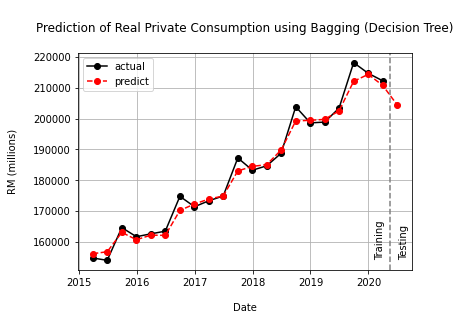

In [17]:
import datetime as dt


plt.plot_date(df_bagging['Date'], df_bagging['PCI'], color = 'black', marker = 'o', label = 'actual', linestyle = '-')
plt.plot_date(df_bagging['Date'], df_bagging['Predictions'], color = 'red', marker = 'o', label = 'predict', linestyle = '--')
plt.legend()
plt.grid()
plt.xlabel('\nDate')
plt.ylabel('RM (millions)\n')
plt.title('\nPrediction of Real Private Consumption using Bagging (Decision Tree)\n')
# plt.axvline(dt.datetime(2018, 12, 31), linestyle= '--', color = 'grey')
plt.axvline(dt.datetime(2020, 5, 15), linestyle= '--', color = 'grey')
# plt.annotate('Training', xy=(dt.datetime(2018, 10, 15), 155000), rotation = 90)
plt.annotate('Training', xy=(dt.datetime(2020, 2, 15), 155000), rotation = 90)
plt.annotate('Testing', xy=(dt.datetime(2020, 7, 15), 155000), rotation = 90)